In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras.layers import Layer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, roc_auc_score, roc_curve
#!pip install seaborn
import seaborn as sns
from tensorflow.keras.utils import plot_model, register_keras_serializable
from sklearn.preprocessing import label_binarize
import tensorflow as tf

In [2]:
@register_keras_serializable(package="Custom", name="SimpleGraphConv")
class SimpleGraphConv(Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        # input_shape = [(batch, N, F), (batch, N, N)]
        F = input_shape[0][-1]
        self.w = self.add_weight(
            shape=(F, self.units),
            initializer="glorot_uniform",
            name="kernel")
        super().build(input_shape)

    def call(self, inputs):
        X, A = inputs    # X: (batch, N, F), A: (batch, N, N)
        return tf.matmul(A, tf.matmul(X, self.w))


@register_keras_serializable(package="Custom", name="GCNTimeDistributed")
class GCNTimeDistributed(Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        # we’ll reuse this conv at each time slice
        self.gcn = SimpleGraphConv(units)

    def build(self, input_shape):
        # input_shape = [(batch, T, N, F), (batch, N, N)]
        # we need to build the inner GCN on a flattened time‐slice shape:
        # pretend batch' = None and time = 1 so shape = (None, N, F) & (None, N, N)
        _, T, N, F = input_shape[0]
        # call inner build:
        self.gcn.build([(None, N, F), (None, N, N)])
        super().build(input_shape)

    def call(self, inputs):
        X, A = inputs
        batch = tf.shape(X)[0]
        T     = tf.shape(X)[1]
        N     = tf.shape(X)[2]
        F     = tf.shape(X)[3]

        # 1) collapse time
        Xr = tf.reshape(X, (batch * T, N, F))
        # 2) tile adjacency
        Aexp = tf.expand_dims(A, 1)               # (batch, 1, N, N)
        Atil = tf.tile(Aexp, [1, T, 1, 1])         # (batch, T, N, N)
        Ar   = tf.reshape(Atil, (batch * T, N, N))
        # 3) apply GCN
        Yr = self.gcn([Xr, Ar])                    # (batch*T, N, units)
        # 4) restore time axis
        return tf.reshape(Yr, (batch, T, N, self.units))

Load train and test data

In [15]:
#X_train = pd.read_csv("./data/X_train_lstm.csv")
X_test = pd.read_csv("./data/X_test_lstm.csv")
X_test_orig = pd.read_csv("./data/old_data/X_test_lstm.csv")
#Y_train = pd.read_csv("./data/Y_train_lstm.csv")
Y_test = pd.read_csv("./data/Y_test_lstm.csv")

X_train_gnn = np.load("./data/X_train_gnn.npy")
A_train     = np.load("./data/A_train.npy")
Y_train     = np.load("./data/Y_train.npy")

#X_test_gnn = np.load("./data/X_test_gnn.npy")
A_test     = np.load("./data/A_test.npy")
#Y_test     = np.load("./data/Y_test.npy")

X_test_gnn_aug = np.load("./data/X_test_gnn_aug.npy")
A_test_aug     = np.load("./data/A_test_aug.npy")
Y_test_aug     = np.load("./data/Y_test_aug.npy")


print("Shapes → X_orig:", X_test.shape, "X_aug:", X_test_orig.shape, "Y_test:", Y_test.shape)

Shapes → X_orig: (316612, 21) X_aug: (317538, 11) Y_test: (316612, 5)


Load LSTM models

In [16]:
model_files = {
    "LSTM":     "./models/lstm_model.keras",
    "BiLSTM":   "./models/bilstm_model.keras",
    "CNN+LSTM":   "./models/hybrid_model.keras",
    #"GNN+LSTM":   "./models/gnn_lstm.keras",
    "LSTM_AUG":     "./models/lstm_model_aug.keras",
    "BiLSTM_AUG":   "./models/bilstm_model_aug.keras",
    "CNN+LSTM_AUG":   "./models/hybrid_model_aug.keras",
    #"GNN+LSTM_AUG":   "./models/gnn_lstm_aug.keras"
}

In [17]:
# 1) raw feature matrices
X_orig = X_test_orig.values    # (n_samples, 11)
X_aug  = X_test.values     # (n_samples, 21)

# 2) your pre-built GNN arrays
X_test_gnn = np.load("./data/X_test_gnn.npy")  # shape (n_samples, T, N, F)
A_test     = np.load("./data/A_test.npy")      # shape (n_samples, N, N)

preds = {}

for name, path in model_files.items():
    # reload model (ensure your GCNTimeDistributed is registered in this notebook)
    model = keras.models.load_model(path)

    # 3) multi-input case: GNN→LSTM
    if isinstance(model.input_shape, list):
        print(f"{name}: multi-input → using GNN data")
        Yhat = model.predict(
            [X_test_gnn, A_test],
            batch_size=32,
            verbose=1
        )

    else:
        # 4) single-input: infer dims
        #    input_shape = (None, ...) so drop first None
        dims = model.input_shape[1:]
        nd   = len(dims)

        if nd == 2:
            # sequence (T, F)
            T, F = dims
            total = T * F
            if total == X_orig.shape[1]:
                X_arr = X_orig
            elif total == X_aug.shape[1]:
                X_arr = X_aug
            else:
                raise ValueError(
                    f"{name} expects {total} features but we only have "
                    f"{X_orig.shape[1]}/{X_aug.shape[1]}"
                )
            X_in = X_arr.reshape(-1, T, F)
            print(f"{name}: single-input (seq) → X_in {X_in.shape}")

        elif nd == 1:
            # flat (F,)
            F, = dims
            if F == X_orig.shape[1]:
                X_in = X_orig
            elif F == X_aug.shape[1]:
                X_in = X_aug
            else:
                raise ValueError(
                    f"{name} expects {F} features but we only have "
                    f"{X_orig.shape[1]}/{X_aug.shape[1]}"
                )
            print(f"{name}: single-input (flat) → X_in {X_in.shape}")

        else:
            raise ValueError(f"{name}: unsupported input dims {dims}")

        Yhat = model.predict(X_in, batch_size=512, verbose=0)

    # 5) collect
    preds[name] = pd.DataFrame(Yhat, columns=Y_test.columns)
    print(f"{name}: predicted {preds[name].shape}")

LSTM: single-input (seq) → X_in (317538, 11, 1)
LSTM: predicted (317538, 5)
BiLSTM: single-input (seq) → X_in (317538, 11, 1)
BiLSTM: predicted (317538, 5)
CNN+LSTM: single-input (seq) → X_in (317538, 11, 1)
CNN+LSTM: predicted (317538, 5)
LSTM_AUG: single-input (seq) → X_in (316612, 21, 1)
LSTM_AUG: predicted (316612, 5)
BiLSTM_AUG: single-input (seq) → X_in (317538, 11, 1)
BiLSTM_AUG: predicted (317538, 5)
CNN+LSTM_AUG: single-input (seq) → X_in (316612, 21, 1)
CNN+LSTM_AUG: predicted (316612, 5)


In [18]:
# path to the file you saved earlier
gnn_path = "./models/gnn_lstm.keras"

# load it with the custom objects map
gnn = keras.models.load_model(
    gnn_path,
    custom_objects={
      "SimpleGraphConv": SimpleGraphConv,
      "GCNTimeDistributed": GCNTimeDistributed
    }
)

# run prediction just like your loop would have
Yhat_gnn = gnn.predict(
    [ X_test_gnn, A_test ],   # your GNN inputs
    batch_size=32,
    verbose=1
)

# stick it into preds under the same five‐column scheme
preds["GNN_LSTM"] = pd.DataFrame(Yhat_gnn, columns=Y_test.columns)

print("Added GNN_LSTM →", preds["GNN_LSTM"].shape)

9924/9924 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
Added GNN_LSTM → (317538, 5)


In [19]:
# path to the file you saved earlier
gnn_path_aug = "./models/gnn_lstm_aug.keras"

# load it with the custom objects map
gnn_aug = keras.models.load_model(
    gnn_path_aug,
    custom_objects={
      "SimpleGraphConv": SimpleGraphConv,
      "GCNTimeDistributed": GCNTimeDistributed
    }
)

# run prediction just like your loop would have
Yhat_gnn_aug = gnn_aug.predict(
    [ X_test_gnn_aug, A_test_aug ],   # your GNN inputs
    batch_size=32,
    verbose=1
)

# stick it into preds under the same five‐column scheme
preds["GNN_LSTM"] = pd.DataFrame(Yhat_gnn_aug, columns=Y_test_aug.columns)

print("Added GNN_LSTM →", preds["GNN_LSTM"].shape)

9895/9895 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

Compute Metrics

In [ ]:
records = []
for name, df_pred in preds.items():
    # raw numpy arrays
    y_true_full = Y_test.values           # shape (n_true, n_vars)
    y_pred_full = df_pred.values          # shape (n_pred, n_vars)

    # find common length
    n_true = y_true_full.shape[0]
    n_pred = y_pred_full.shape[0]
    n = min(n_true, n_pred)
    if n_true != n_pred:
        print(f"Warning: {name} true/pred length {n_true}/{n_pred}, truncating to {n}")

    # truncate
    y_true = y_true_full[:n]
    y_pred = y_pred_full[:n]

    # compute per‐variable metrics
    for j, var in enumerate(Y_test.columns):
        records.append({
            "Model":    name,
            "Variable": var,
            "MAE":      mean_absolute_error(y_true[:, j], y_pred[:, j]),
            "RMSE":     np.sqrt(mean_squared_error(y_true[:, j], y_pred[:, j])),
            "R2":       r2_score(y_true[:, j], y_pred[:, j]),
        })

metrics_df = pd.DataFrame(records)
display(
    metrics_df
      .pivot(index="Variable", columns="Model", values=["MAE","RMSE","R2"])
)

MAE                             RMSE  \
Model                       BiLSTM   CNN+LSTM       LSTM     BiLSTM   
Variable                                                              
DELAY_DUE_CARRIER        18.766558  18.777309  18.497713  27.010635   
DELAY_DUE_LATE_AIRCRAFT  23.922354  23.768764  23.946260  30.874227   
DELAY_DUE_NAS            13.426551  13.954420  13.705234  20.954715   
DELAY_DUE_SECURITY        0.292310   0.271716   0.312000   2.168528   
DELAY_DUE_WEATHER         4.445875   4.396444   4.604500  11.125301   

                                                     R2                      
Model                     CNN+LSTM       LSTM    BiLSTM  CNN+LSTM      LSTM  
Variable                                                                     
DELAY_DUE_CARRIER        27.149766  27.005963 -0.087509 -0.098741 -0.087133  
DELAY_DUE_LATE_AIRCRAFT  30.825834  31.041489 -0.180962 -0.177263 -0.193792  
DELAY_DUE_NAS            21.346025  21.107477 -0.378959 -0.430941 -0.399138  
DELAY_DUE_SECURITY        2.169294   2.169464 -0.002408 -0.003116 -0.003274  
DELAY_DUE_WEATHER        11.187745  11.180430 -0.027398 -0.038964 -0.037605

ValueError: x and y must be the same size

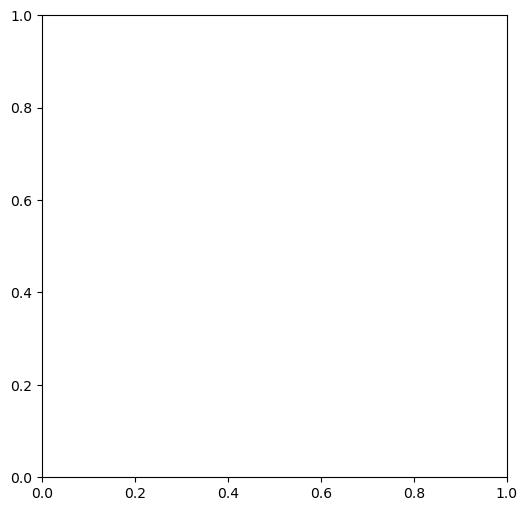

In [ ]:
plt.figure(figsize=(6,6))
for name, Yhat in preds.items():
    plt.scatter(
        Y_test.values.ravel(),
        Yhat.values.ravel(),
        alpha=0.3,
        s=10,
        label=name
    )
plt.plot(
    [Y_test.values.min(), Y_test.values.max()]*2,
    [Y_test.values.min(), Y_test.values.max()]*2,
    "k--",
    label="Perfect"
)
plt.legend()
plt.xlabel("True Delay (mins)")
plt.ylabel("Predicted Delay (mins)")
plt.title("Predicted vs True Delay")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# ─── Cell 7: AUC curves for delay‐categories ──────────────────────────────────


# 1) bin continuous delays into K classes
bins   = [0, 5, 15, 30, 60, np.inf]
labels = list(range(len(bins)-1))
delay_cat = pd.cut(Y_test.values.ravel(), bins=bins, labels=labels).astype(int)
y_true_cat = delay_cat.to_numpy()
classes    = np.unique(y_true_cat)
y_true_bin = label_binarize(y_true_cat, classes=classes)

# 2) build a one‐hot “probability” from each regressor by assigning all mass to nearest bin
def to_proba(y_cont):
    # assign each continuous prediction to its bin, then one-hot
    idx = np.digitize(y_cont, bins) - 1
    proba = np.eye(len(classes))[idx]
    return proba

# 3) compute & plot per‐model
for name, Yhat in preds.items():
    y_proba = to_proba(Yhat.values.ravel())
    aucs    = roc_auc_score(y_true_bin, y_proba, multi_class='ovr', average=None)

    plt.figure(figsize=(6,6))
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:,i], y_proba[:,i])
        plt.plot(fpr, tpr, label=f"Class {cls} (AUC={aucs[i]:.2f})")
    plt.plot([0,1],[0,1],"k--", label="Chance")
    plt.title(f"ROC Curves ({name})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


In [ ]:
# 4) Pivot for bar charts
mae_df  = metrics.pivot(index="Variable", columns="Model", values="MAE")
rmse_df = metrics.pivot(index="Variable", columns="Model", values="RMSE")
r2_df   = metrics.pivot(index="Variable", columns="Model", values="R2")

In [ ]:
# 5) Plot MAE / RMSE / R² side by side
fig, axes = plt.subplots(3, 1, figsize=(12, 16))

mae_df.plot.bar(ax=axes[0])
axes[0].set_title("Mean Absolute Error by Model & Variable")
axes[0].set_ylabel("MAE")

rmse_df.plot.bar(ax=axes[1])
axes[1].set_title("Root MSE by Model & Variable")
axes[1].set_ylabel("RMSE")

r2_df.plot.bar(ax=axes[2])
axes[2].set_title("R² Score by Model & Variable")
axes[2].set_ylabel("R²")

for ax in axes:
    ax.legend(title="Model")
    ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
# 6) Aggregate scatter: Predicted vs True (all models, all vars)
plt.figure(figsize=(6,6))
mn, mx = Y_test.values.min(), Y_test.values.max()
plt.plot([mn,mx], [mn,mx], "k--", label="Perfect")

for name, Y_pred in preds.items():
    plt.scatter(
        Y_test.values.ravel(),
        Y_pred.values.ravel(),
        alpha=0.3,
        label=name,
        s=10
    )

plt.legend()
plt.xlabel("True Delay (mins)")
plt.ylabel("Predicted Delay (mins)")
plt.title("Predicted vs True Delay (All Models & Variables)")
plt.tight_layout()
plt.show()

In [ ]:
# 7) Error‐distribution KDE
plt.figure(figsize=(10,5))
for name, Y_pred in preds.items():
    errs = (Y_pred.values - Y_test.values).ravel()
    sns.kdeplot(errs, label=name, fill=True)

plt.legend()
plt.title("Error Distribution by Model")
plt.xlabel("Prediction Error (mins)")
plt.tight_layout()
plt.show()

MSE and MAE

In [ ]:
mean_squared_error(Y_test, Y_pred)

361.1148094700631

In [ ]:
mean_absolute_error(Y_test, Y_pred)  # mins

10.083698641605949

Standard deviation

In [ ]:
for col in Y_pred.columns:
    print(col)
    print(Y_test[col].std(), Y_pred[col].std())

DELAY_DUE_CARRIER
25.567373882087463 7.6205435
DELAY_DUE_WEATHER
11.406046218751655 0.93484366
DELAY_DUE_SECURITY
2.4229327308810777 0.12023699
DELAY_DUE_NAS
19.65953564135613 11.143993
DELAY_DUE_LATE_AIRCRAFT
29.452996135802763 9.612298


Mean of predictions

In [ ]:
Y_pred.mean()

DELAY_DUE_CARRIER          16.751114
DELAY_DUE_WEATHER           2.335597
DELAY_DUE_SECURITY          0.190225
DELAY_DUE_NAS              11.991378
DELAY_DUE_LATE_AIRCRAFT    18.397444
dtype: float32

### Plot box plots of predicted test labels and true labels

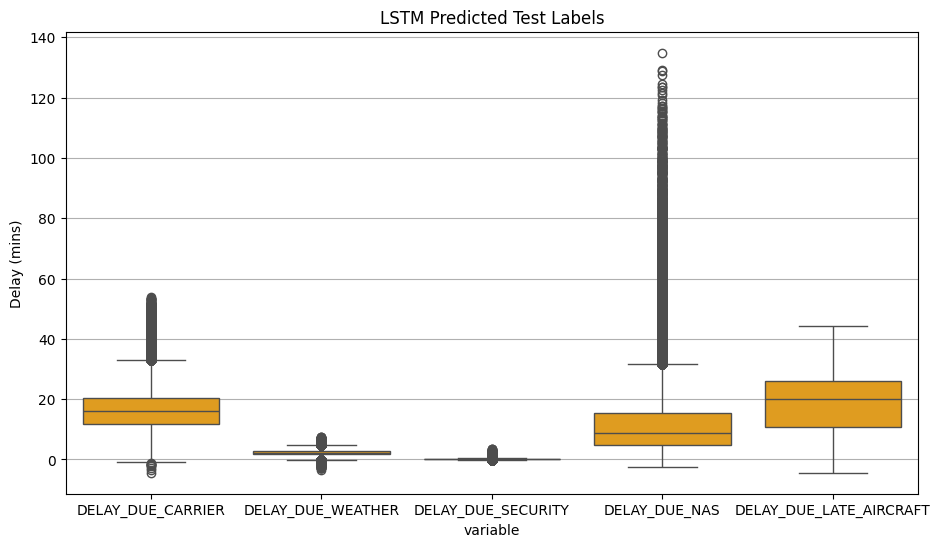

In [ ]:
plt.figure(figsize=(11, 6))
plt.grid()
sns.boxplot(Y_pred.melt(), x="variable", y="value", color="orange")
plt.title('LSTM Predicted Test Labels')
plt.ylabel("Delay (mins)")
plt.show()

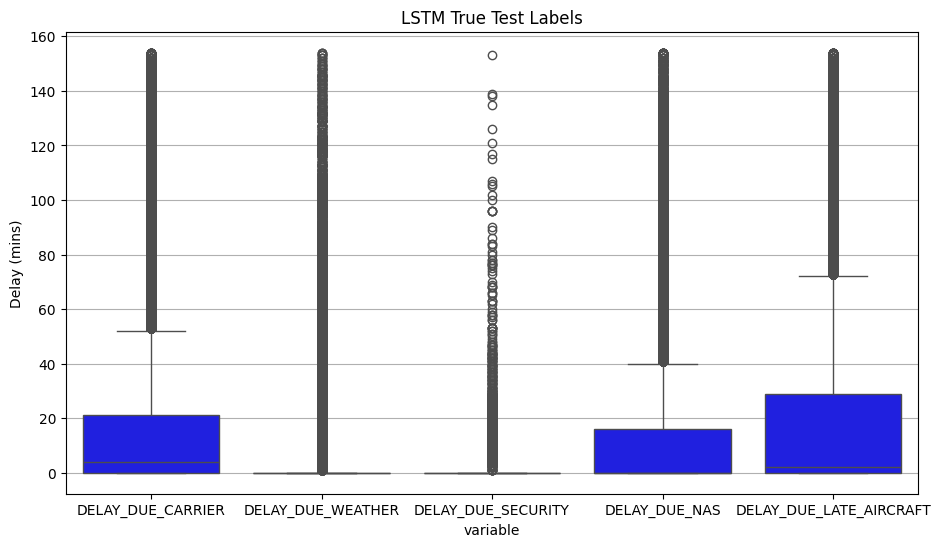

In [ ]:
plt.figure(figsize=(11, 6))
plt.grid()
sns.boxplot(Y_test.melt(), x="variable", y="value", color="blue")
plt.title('LSTM True Test Labels')
plt.ylabel("Delay (mins)")
plt.show()

In [ ]:
y_true = np.array([...], dtype=int)      # shape (n_samples,)
y_pred_proba = model.predict(X_test)     # shape (n_samples, C)

In [ ]:
# ─── 1) number of classes 
classes = np.unique(y_true)
n_classes = len(classes)

In [ ]:
# ─── 2) compute AUC per class ─────────────────────────────────────────────────
# multi_class='ovr' gives one‐vs‐rest; average=None returns array of per‐class AUCs
auc_scores = roc_auc_score(
    y_true,
    y_pred_proba,
    multi_class='ovr',
    average=None
)

for i, cls in enumerate(classes):
    print(f"Class {cls} AUC = {auc_scores[i]:.4f}")

In [ ]:
plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    # get binary labels for this class
    y_true_bin = (y_true == cls).astype(int)
    fpr, tpr, _ = roc_curve(y_true_bin, y_pred_proba[:, i])
    plt.plot(fpr, tpr, label=f"Class {cls} (AUC={auc_scores[i]:.3f})")

# plot the chance line
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC Curves by Delay Category")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
hybrid_model = keras.models.load_model("./models/hybrid_model.keras")

In [ ]:
!pip install pydot graphviz

In [ ]:
plot_model(hybrid_model,to_file="hybrid_model_architecture.png", show_shapes=True, show_layer_names=False)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
Y_pred = hybrid_model.predict(X_test)

3827/3827 [==============================] - 13s 3ms/step


In [ ]:
mean_squared_error(Y_test, Y_pred)

370.4797229216997

In [ ]:
mean_absolute_error(Y_test, Y_pred)

10.5174843329492